##### Grupo:
    - Débora Noemy de Alcântara Valentim
    - Gabriel Soares Vasconcelos Lira
    - Lucas Loureiro Albuquerque da Silva Eloi

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.utils import resample
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

## Análise exploratória dos dados ##
 - Os dados foram obtidos no Kaggle, contém informações sobre a avaliação de posições de tabuleiros de xadrez: https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations

Primeiramente, para começarmos a fazer uma análise exploratória para decidir os objetivos, devemos entender a estrutura dos dados com os quais estamos lidando.
Os dados estão divididos em 3 tabelas.
 - chessData contém informações sobre estados de tabuleiros na notação FEN, e a avaliação dele em centipawns (1/100 do valor de um peão)
 - random_evals contém diversos tabuleiros montados aleatoriamente a partir de diversas jogadas, e a avaliação dele em centipawns
 - tactic_evals é similar ao chessData, mas além disso, possui o melhor movimento possível naquele tabuleiro decidido com auxilio da ferramenta Linchess
#### Entender a notação FEN ####
 - A notação FEN é composta por 8 linhas, cada uma contendo peças, em maiusculo para brancas e minusculo para pretas, tendo um número de 1-8 indicando quantas casas vazias entre uma peça e outra. Após isso temos letras para ver a notação sobre de quem é o turno, possibilidade de roques e en passants
#### Centipawns #####
 - Outro fator comum entre todos os datasets é a avaliação do stockfish em centipawns, onde vão existir duas variações, as com # que indicam mate naquela posição, e as sem mate que indicam apenas a avaliação geral do tabuleiro
#### Move ####
 - A base de dados tactic_evals contém uma coluna Move, que contém informações da melhor jogada do Linchess, contendo a cordenada atual e a cordenada futura



In [10]:
# Caminho para o arquivo kaggle.json no ambiente do supercomputador
kaggle_json_path = "kaggle.json"  # Substitua pelo caminho correto

# Configuração do Kaggle
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
os.system(f"cp {kaggle_json_path} ~/.kaggle/")
os.system("chmod 600 ~/.kaggle/kaggle.json")

# Instalação do cliente do Kaggle
!pip install kaggle


Defaulting to user installation because normal site-packages is not writeable


In [11]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip list | grep wandb

wandb                         0.19.0


In [13]:
# Verifique se o Kaggle está configurado
assert os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")), "Arquivo kaggle.json não encontrado!"

# Baixe o dataset
!kaggle datasets download -d ronakbadhe/chess-evaluations --unzip -p ./chess_data

Dataset URL: https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations
License(s): other
 98%|███████████████████████████████████████▎| 196M/200M [00:06<00:00, 30.1MB/s]
100%|████████████████████████████████████████| 200M/200M [00:06<00:00, 29.9MB/s]


In [5]:
chessData = pd.read_csv('chess_data/chessData.csv')
random_evals = pd.read_csv('chess_data/random_evals.csv')
tactic_evals = pd.read_csv('chess_data/tactic_evals.csv')

In [6]:
print(chessData.head())
print(random_evals.head())
print(tactic_evals.head())

                                                 FEN Evaluation
0  rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...        -10
1  rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...        +56
2  rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...         -9
3  rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...        +52
4  rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...        -26
                                                 FEN Evaluation
0  rnbqkb1r/pppppppp/B4n2/8/4P3/8/PPPP1PPP/RNBQK1...       -459
1  rnbqkb1r/pppppppp/5n2/1B6/4P3/8/PPPP1PPP/RNBQK...       -125
2  rnbqkbnr/p1pppppp/8/1p6/4P3/8/PPPP1PPP/RNBQKBN...       +198
3  rnbqkb1r/pppppppp/5n2/8/4P3/7N/PPPP1PPP/RNBQKB...       -155
4  rnbqkbnr/ppppp1pp/8/5p2/4P3/8/PPPP1PPP/RNBQKBN...       +209
                                                 FEN Evaluation  Move
0  r2qkbr1/pb1nn3/1ppp3p/8/3P1p2/2PB1N1P/PPQN1PP1...        #+2  d3g6
1  r2qkb2/pb1nn3/1ppp2rp/8/3P1p2/2P2N1P/PPQN1PP1/...        #+1  c2g6
2  r2qkbr1/pb1nn3/1ppp

In [11]:
data_mates = chessData['Evaluation'][chessData['Evaluation'].str.contains('#', na=False)]
data_mates

59           #+6
60           #+6
61           #+4
62           #+3
1440        #-19
            ... 
12957453     #+8
12957454     #+9
12957551     #-6
12957552     #-5
12957780     #+1
Name: Evaluation, Length: 190154, dtype: object

In [12]:
# Averiguando o comprimento das jogadas, é possível perceber que certos movimentos possuem 5 letras, para representar peões promovidos
dif_len_moves = tactic_evals[tactic_evals['Move'].str.len() != 4]
dif_len_moves

,FEN,Evaluation,Move
62,r2qkb2/pb1nn3/1ppp2Qp/8/3P1p2/2P2N1P/PP1N1PP1/...,#+0,NaN
63,8/7p/5Rp1/2p1pkP1/7P/P4PK1/1r6/3q4 b - - 7 46,#+0,NaN
64,2R2k2/6b1/3N1r1p/r2b2p1/2p5/3p4/P4PPP/2B1R1K1 ...,#+0,NaN
65,k1Q5/pp2p3/2p5/4B3/7q/4N3/PP6/2K5 b - - 0 40,#+0,NaN
66,4R1k1/2q2pp1/5b1p/p4B2/1pN5/1P5P/P4PP1/6K1 b -...,#+0,NaN
...,...,...,...
2627644,1r4r1/5ppk/p3p3/2q1PP2/2pp4/P5NQ/1P4PP/1b5K b ...,#+0,NaN
2627820,r1b1k2r/pp1p1pPp/4p3/8/8/4qP2/PPPKNb1P/R1BQ1B1...,#-0,NaN
2627826,5Nkr/pbp2pp1/1p2p3/1B6/P2P3p/2P4n/2PQ1P1P/R4RK...,#-0,NaN
2627915,1k5r/p7/Qp2p3/R1ppNp2/3P1n2/2P3q1/2P5/5RK1 w -...,#-0,NaN


## Pré-processamento dos dados ##

Formato de um código FEN: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1

Para utilizar esses dados em um modelo de IA, precisamos fazer algums tratamentos para transformar eles em um input

#### Pré-processamento código FEN ####

- Tokenização: Podemos análisar o código mais facilmente tokenizando o valor para os valores presentes em suas linhas

- Remoção de dados irrelevantes: Para nosso objetivo, que não envolve validação de jogadas, as informações após o tabuleiro não são úteis

- Converter números para 0: Transformar um número naquela quantidade de 0's é importante para representar as casas vazias

- Conversão para matriz: Utilizando a pontuação de sarrat para converter peças em números e transformar o código em uma matriz 8x8

#### Pré-processamento evaluation ####

 - Cheques: Para transformar esses dados em algo mais legível, os cheques serão tratados para existir uma colunas apenas com valores boleanos, se aquele tabuleiro esta com mate ou não, mantendo a coluna de evaluation separada

#### Pré-processamento jogada (tactic_evals) ####

- Tokenização: Similarmente a como fizemos com a notação FEN, para as jogadas, iremos separar os valores em tokens por letra

- Tratar peça extra: Jogadas que envolvem promoções de peões, possuem um algarismo a mais denotando a peça para a qual ele foi promovido, portanto, irei realizar a substituição dessa peça, pela pontuação de sarrat equivalente, e acrecentar um valor 0 ao final dos tokens que não possuem ela para manter as entradas no mesmo formato sem ter perca de informação

- Conversão tokens: Para simplificar o entendimento pelo modelo, não seria um problema para a notação, substituir o valor das letras, por seu equivalente numérico, que na prática é a mesma coisa nesse contexto



In [8]:
checkmate_rows = chessData[chessData['Evaluation'].str.contains('#')]
non_checkmate_rows = chessData[~chessData['Evaluation'].str.contains('#')]

print(f"Número de Checkmates: {len(checkmate_rows)}")
print(f"Número de Não Checkmates: {len(non_checkmate_rows)}")


Número de Checkmates: 190154
Número de Não Checkmates: 12767881


In [9]:
# Subamostrar a classe Não Checkmate
non_checkmate_sampled = resample(
    non_checkmate_rows,
    replace=False,
    n_samples=len(checkmate_rows),  # Igualar ao número de Checkmates
    random_state=42
)

# Combinar as classes balanceadas
balanced_data = pd.concat([checkmate_rows, non_checkmate_sampled])

# Misturar as amostras
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)


In [14]:
balanced_data

,FEN,Evaluation
0,1r4k1/2n3bp/pN1p2p1/P1pPp3/8/1rBq1P1P/RPQ2RP1/...,-57
1,8/k3Kp2/2QB1P2/8/6q1/8/5P2/8 w - - 3 71,#+4
2,6k1/p2n3p/2bP4/2p2ppq/2N5/1PQ4P/PB6/4R1K1 b - ...,#+7
3,r2k4/N7/1KP5/8/1P4p1/6B1/8/8 w - - 2 63,#+15
4,b2rqrk1/p1p5/1p2p2Q/1P2Pp2/2P5/PR6/2B3PP/3R2K1...,#+7
...,...,...
380303,1k6/2p1r3/1p1p1pq1/pP1P3p/P2QPR2/6KP/6P1/8 w -...,0
380304,3r1rk1/pb2bppp/2p1p3/8/3PB3/2B5/PP2KPPP/R2R4 b...,-12
380305,r2q2kr/ppp1nR2/2np3p/6pB/NP2P1N1/2PPP3/P5PP/R2...,#+1
380306,1R2R3/5p1k/p6p/3p3b/2p3pq/2P3p1/P2N1bP1/5N1K w...,#-1


In [21]:
#Reduzindo o tamanho dos dados para ser gentil com meu notebook
# chessData = chessData[0:500000]
# tactic_evals = tactic_evals[0:500]

In [22]:
tactic_evals = tactic_evals.dropna()

In [22]:
sarrat = {
    'P':1,
    'N':3.1,
    'B':3.3,
    'R':5,
    'Q':7.9,
    'K':2.2,
    'p':-1,
    'n':-3.1,
    'b':-3.3,
    'r':-5,
    'q':-7.9,
    'k':-2.2,
    '0': 0
}
letters = ['a','b','c','d','e','f','g','h']

In [23]:
# Operações para tratar boards
def separate_board(board):
    return board['FEN'].apply(lambda x: x.replace('/', ' ').split()).tolist()

def remove_extras(board):
    return [row[:8] for row in board]

def num_to_zeros(board):
    return [
        [re.sub(r'[1-9]', lambda x: '0' * int(x.group()), cell) if isinstance(cell, str) else cell for cell in row]
        for row in board
    ]

def fen_to_matrix(board):
    if isinstance(board, pd.DataFrame):
        board = board.iloc[:, 0].tolist()

    matrix = []
    for row in board:
        row_a = []
        for piece in row:
            if piece in sarrat:
                row_a.append(sarrat[piece])
            else:
                row_a.append(0)
        matrix.append(row_a)
    return matrix

def fen_in_column(board_column):
    return [fen_to_matrix(row) for row in board_column]


#Operações para tratar movimentos

def separate_move(move):
    return [list(i) for i in move]


def normalize_size(move):
    norm_moves = []
    for row in move:
        if len(row) == 4:
            row.append('0')
        norm_moves.append(row)
    return norm_moves



def coords_to_numbers(moves):
    num_moves = []
    for cord in moves:
        num_move = []
        for i in cord:
            if i in letters:
                num_move.append(letters.index(i))
            elif i.isdigit():
                num_move.append(int(i) - 1)
        num_moves.append(num_move)
    return num_moves


#Operações para evaluation

def mate_column(evaluation):
    return ('#' in evaluation)



In [24]:
pipeline_transform_fen = Pipeline([
    ('Separate board into lines', FunctionTransformer(separate_board)),
    ('Remove no-board info', FunctionTransformer(remove_extras)),
    ('Convert num to zeros', FunctionTransformer(num_to_zeros)),
    ('Convert fen notation to matrix', FunctionTransformer(fen_in_column))
])

In [25]:
pipeline_transform_move = Pipeline([
    ('Separate move', FunctionTransformer(separate_move)),
    ('Normalize size', FunctionTransformer(normalize_size)),
    ('Convert coords to numbers', FunctionTransformer(coords_to_numbers))
])

In [27]:
cleared_chess_data = balanced_data.copy()

print(cleared_chess_data['FEN'].head())
cleared_chess_data['FEN'] = pipeline_transform_fen.fit_transform(cleared_chess_data[['FEN']])

cleared_chess_data['MATE'] = cleared_chess_data['Evaluation'].apply(mate_column)
cleared_chess_data.head()

0    1r4k1/2n3bp/pN1p2p1/P1pPp3/8/1rBq1P1P/RPQ2RP1/...
1              8/k3Kp2/2QB1P2/8/6q1/8/5P2/8 w - - 3 71
2    6k1/p2n3p/2bP4/2p2ppq/2N5/1PQ4P/PB6/4R1K1 b - ...
3              r2k4/N7/1KP5/8/1P4p1/6B1/8/8 w - - 2 63
4    b2rqrk1/p1p5/1p2p2Q/1P2Pp2/2P5/PR6/2B3PP/3R2K1...
Name: FEN, dtype: object


,FEN,Evaluation,MATE
0,"[[0, -5, 0, 0, 0, 0, -2.2, 0], [0, 0, -3.1, 0,...",-57,False
1,"[[0, 0, 0, 0, 0, 0, 0, 0], [-2.2, 0, 0, 0, 2.2...",#+4,True
2,"[[0, 0, 0, 0, 0, 0, -2.2, 0], [-1, 0, 0, -3.1,...",#+7,True
3,"[[-5, 0, 0, -2.2, 0, 0, 0, 0], [3.1, 0, 0, 0, ...",#+15,True
4,"[[-3.3, 0, 0, -5, -7.9, -5, -2.2, 0], [-1, 0, ...",#+7,True


In [28]:
# Não usamos a tactic_evals no momento 
# cleared_tactic_evals = tactic_evals.copy()

# cleared_tactic_evals['Move'] = pipeline_transform_move.fit_transform(cleared_tactic_evals['Move'])
# cleared_tactic_evals['FEN'] = pipeline_transform_fen.fit_transform(cleared_tactic_evals[['FEN']])
# cleared_tactic_evals['MATE'] = mate_column(cleared_tactic_evals['Evaluation'])


In [29]:
#from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Concatenate, Input, Conv2D
#from tensorflow.keras.models import Model
#sfrom tensorflow.keras.callbacks import EarlyStopping

In [30]:
# Suponha que cleared_chess_data já está processado
X = np.stack(cleared_chess_data['FEN'].to_numpy())  # Converte as matrizes para um array 3D
y = cleared_chess_data['MATE'].astype(int).to_numpy()  # Converte o alvo para 0/1

# Normalizar os dados
X = X / np.max(np.abs(X))

# Adicionar uma dimensão de canal
X = X[..., np.newaxis]

# Dividir os dados em treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Formato do conjunto de treinamento: {X_train.shape}")
print(f"Formato do conjunto de validação: {X_val.shape}")

Formato do conjunto de treinamento: (304246, 8, 8, 1)
Formato do conjunto de validação: (76062, 8, 8, 1)


Distribuição das Classes: {0: 190154, 1: 190154}


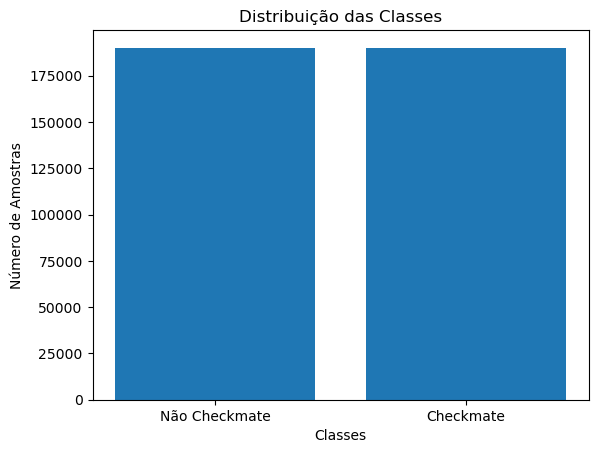

In [31]:
# Verificar a distribuição das classes
unique, counts = np.unique(y, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Distribuição das Classes:", class_distribution)

# Visualizar graficamente
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title("Distribuição das Classes")
plt.xlabel("Classes")
plt.ylabel("Número de Amostras")
plt.xticks([0, 1], ["Não Checkmate", "Checkmate"])
plt.show()


In [32]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam

# Inicializar W&B
wandb.init(project="chess_evaluation", config={
    "epochs": 20,
    "batch_size": 32,
    "optimizer": "adam",
    "learning_rate": 0.001,
    "dropout": 0.3,
    "l2_regularization": 0.001,
    "architecture": "2 Conv2D layers, 1 Dense"
})

config = wandb.config

# Modelo
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(8, 8, 1)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(config.l2_regularization)),
    Dropout(config.dropout),
    Dense(1, activation='sigmoid')
])

# Selecionar otimizador
if config.optimizer == "adam":
    optimizer = Adam(learning_rate=config.learning_rate)
elif config.optimizer == "rmsprop":
    optimizer = RMSprop(learning_rate=config.learning_rate)

# Compilar
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: loureirolucas98 (loureirolucas98-ufrn). Use `wandb login --relogin` to force relogin


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 6, 32)          320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

# Inicializar o W&B
wandb.init(project="chess_evaluation", config={
    "epochs": 20,
    "batch_size": 32,
    "optimizer": "adam",
    "architecture": "2 Conv2D layers, 1 Dense"
})

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinar
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=wandb.config.epochs,
    batch_size=wandb.config.batch_size,
    callbacks=[
        WandbMetricsLogger(),
        WandbModelCheckpoint(filepath="model.keras"),
        early_stopping
    ]
)

2024-12-09 22:37:05.236881: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-12-09 22:37:05.298087: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2099745000 Hz


Epoch 1/20


2024-12-09 22:37:06.296423: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-12-09 22:37:06.792072: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-12-09 22:37:09.454185: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-12-09 22:37:09.790617: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


9508/9508 [==============================] - 88s 7ms/step - loss: 0.4444 - accuracy: 0.8083 - val_loss: 0.3725 - val_accuracy: 0.8406
Epoch 2/20
9508/9508 [==============================] - 35s 4ms/step - loss: 0.3753 - accuracy: 0.8417 - val_loss: 0.3489 - val_accuracy: 0.8556
Epoch 3/20
9508/9508 [==============================] - 35s 4ms/step - loss: 0.3625 - accuracy: 0.8491 - val_loss: 0.3494 - val_accuracy: 0.8548
Epoch 4/20
9508/9508 [==============================] - 35s 4ms/step - loss: 0.3518 - accuracy: 0.8542 - val_loss: 0.3392 - val_accuracy: 0.8599
Epoch 5/20
9508/9508 [==============================] - 35s 4ms/step - loss: 0.3497 - accuracy: 0.8563 - val_loss: 0.3362 - val_accuracy: 0.8606
Epoch 6/20
9508/9508 [==============================] - 34s 4ms/step - loss: 0.3449 - accuracy: 0.8579 - val_loss: 0.3299 - val_accuracy: 0.8640
Epoch 7/20
9508/9508 [==============================] - 34s 4ms/step - loss: 0.3420 - accuracy: 0.8592 - val_loss: 0.3390 - val_accuracy: 0.8

               precision    recall  f1-score   support

Não Checkmate       0.89      0.83      0.86     38004
    Checkmate       0.84      0.90      0.87     38058

     accuracy                           0.86     76062
    macro avg       0.87      0.86      0.86     76062
 weighted avg       0.87      0.86      0.86     76062



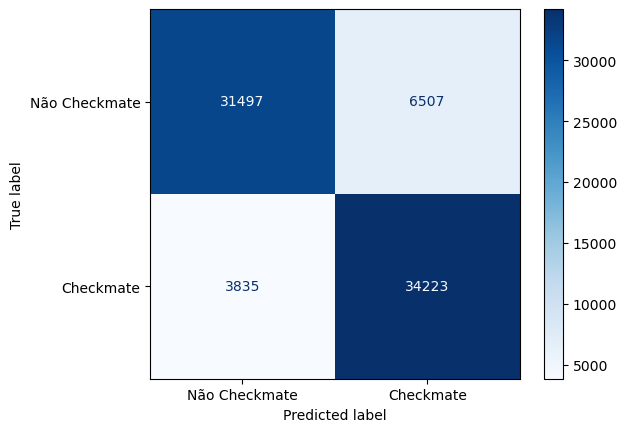

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Fazer predições
y_pred = (model.predict(X_val) > 0.5).astype(int)

# Relatório detalhado
print(classification_report(y_val, y_pred, target_names=["Não Checkmate", "Checkmate"]))

# Matriz de confusão
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Não Checkmate", "Checkmate"])
disp.plot(cmap=plt.cm.Blues)
plt.show()



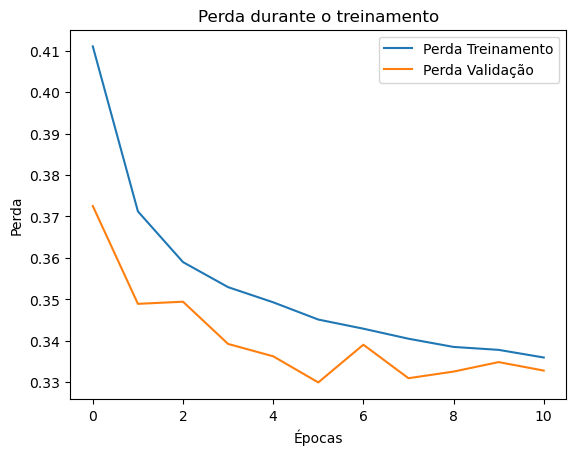

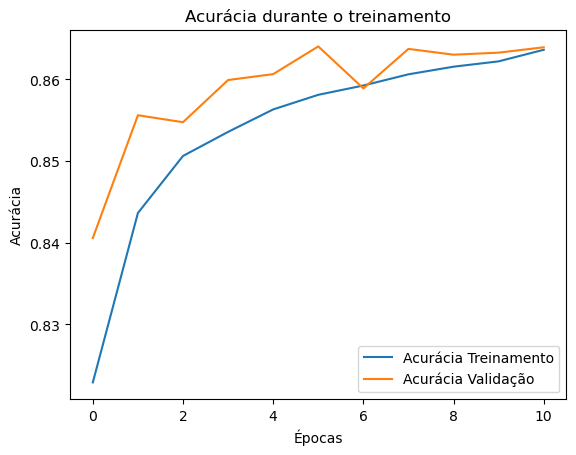

In [35]:
# Plotar perda
plt.plot(history.history['loss'], label='Perda Treinamento')
plt.plot(history.history['val_loss'], label='Perda Validação')
plt.legend()
plt.title('Perda durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.show()

# Plotar acurácia
plt.plot(history.history['accuracy'], label='Acurácia Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.legend()
plt.title('Acurácia durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.show()


In [39]:
from tensorflow.keras.models import load_model

# Carregar o modelo salvo
modelo_caminho = "model.keras"  
model = load_model(modelo_caminho)

In [44]:
# Filtrar entradas que foram deixadas de fora do treinamento (não balanceadas)
dados_excluidos = chessData[~chessData.index.isin(balanced_data.index)]

amostras_para_predicao = dados_excluidos.sample(5)  # Alterar o número conforme necessário

# Extrair os códigos FEN das amostras selecionadas
fens_para_predicao = amostras_para_predicao['FEN'].tolist()

# Transformar as amostras usando o pipeline
# O pipeline foi definido anteriormente para ser aplicado nas colunas FEN
fens_df = pd.DataFrame({'FEN': fens_para_predicao})  # Convertendo para DataFrame

matrizes_para_predicao = pipeline_transform_fen.transform(fens_df)

# Verificando se as matrizes têm o formato correto
for i, matrix in enumerate(matrizes_para_predicao):
    if len(matrix) != 8 or len(matrix[0]) != 8:
        print(f"Erro na matriz {i+1}, forma inválida: {len(matrix)}x{len(matrix[0])}")
    else:
        print(f"Matriz {i+1} está correta com forma: {len(matrix)}x{len(matrix[0])}")

# Normalizar as matrizes como feito durante o treinamento
matrizes_para_predicao = np.array(matrizes_para_predicao)
matrizes_para_predicao = matrizes_para_predicao / np.max(np.abs(matrizes_para_predicao))

# Adicionar a dimensão do canal (1 para imagens em escala de cinza)
matrizes_para_predicao = matrizes_para_predicao[..., np.newaxis]

# Fazer as predições
predicoes = model.predict(matrizes_para_predicao)

# Exibir os resultados
print("Predições para Entradas Não Utilizadas no Treinamento:")
for fen, pred in zip(fens_para_predicao, predicoes):
    print(f"Código FEN: {fen}")
    print(f"Probabilidade de Checkmate: {pred[0]:.4f}")
    print("-" * 50)

Matriz 1 está correta com forma: 8x8
Matriz 2 está correta com forma: 8x8
Matriz 3 está correta com forma: 8x8
Matriz 4 está correta com forma: 8x8
Matriz 5 está correta com forma: 8x8
Predições para Entradas Não Utilizadas no Treinamento:
Código FEN: 4r3/1p2k1pp/r1p5/p1n5/P1P1Pp2/2N2P2/1PR2K1P/6R1 b - - 1 28
Probabilidade de Checkmate: 0.2321
--------------------------------------------------
Código FEN: 1r4rk/1p1q1p1p/p3npb1/3pp3/PP4QN/1BPPR1PP/5P1K/R7 w - - 0 24
Probabilidade de Checkmate: 0.0651
--------------------------------------------------
Código FEN: 4n3/p2k2p1/1p3p1p/5P1P/1BP3P1/1P6/PK1Q2q1/8 b - - 6 41
Probabilidade de Checkmate: 0.8129
--------------------------------------------------
Código FEN: 1r2kn1r/1p1bqp2/p2p1bp1/2pP2np/2P1PP1P/2N1Q3/PP1BB3/2K2R1R w k - 0 18
Probabilidade de Checkmate: 0.0115
--------------------------------------------------
Código FEN: 1R6/5ppk/5n1p/4pP2/4P3/5BP1/r4r1P/1R4K1 w - - 1 35
Probabilidade de Checkmate: 0.7182
-------------------------

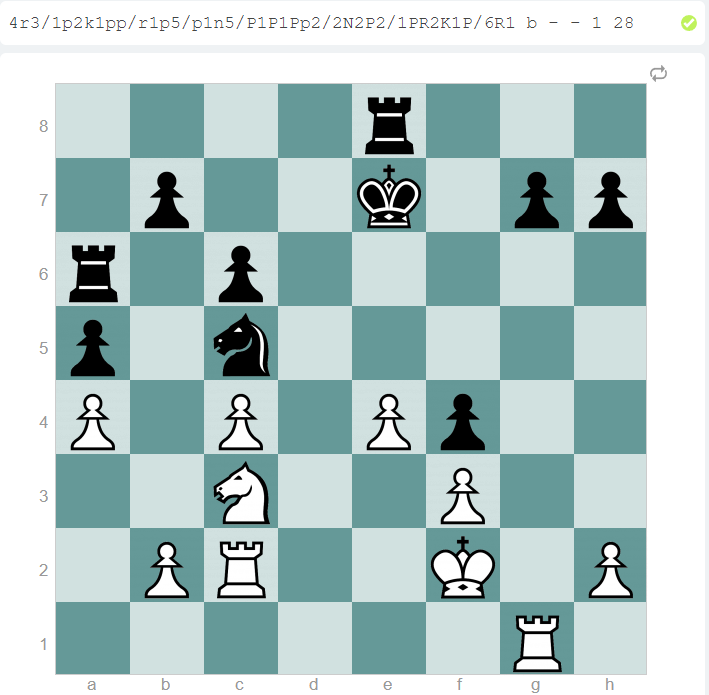

Código FEN: 4r3/1p2k1pp/r1p5/p1n5/P1P1Pp2/2N2P2/1PR2K1P/6R1 b - - 1 28
Probabilidade de Checkmate: 0.2321
--------------------------------------------------


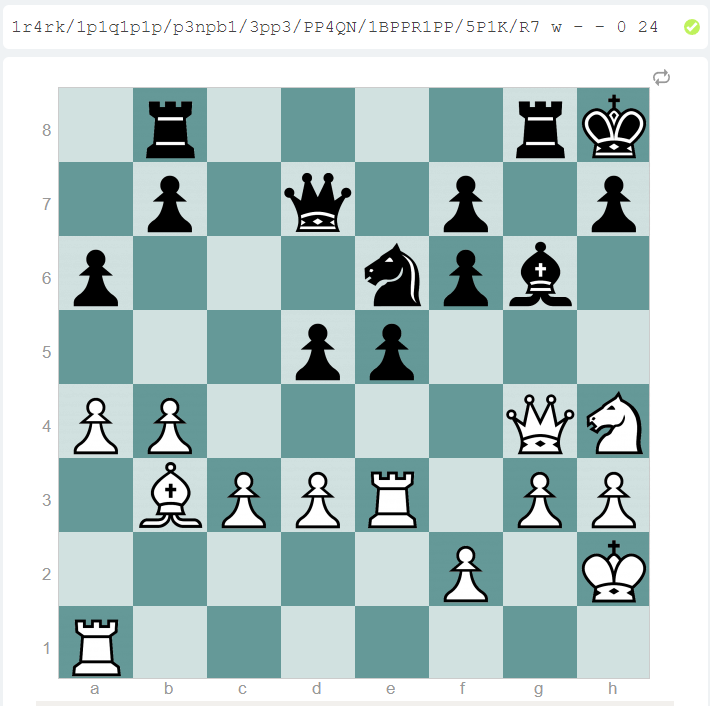

Código FEN: 1r4rk/1p1q1p1p/p3npb1/3pp3/PP4QN/1BPPR1PP/5P1K/R7 w - - 0 24
Probabilidade de Checkmate: 0.0651
--------------------------------------------------


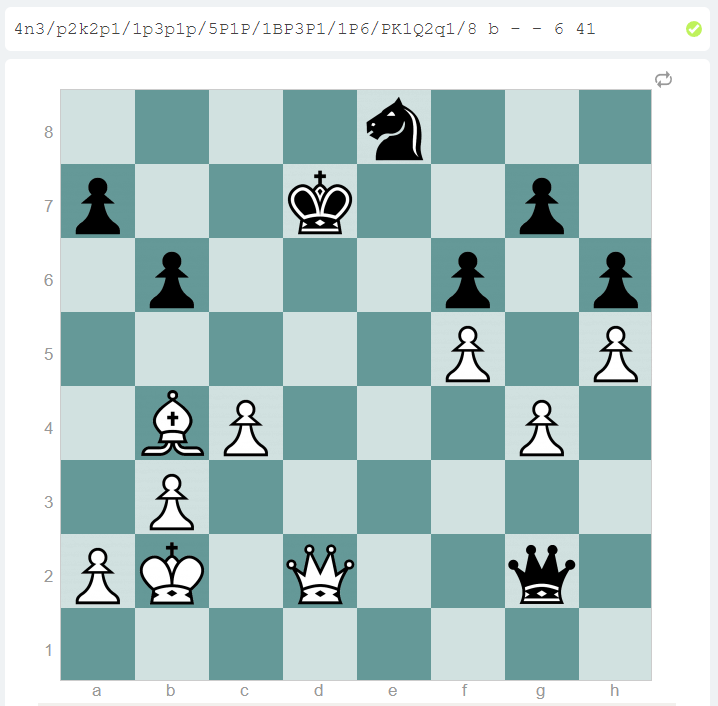

Código FEN: 4n3/p2k2p1/1p3p1p/5P1P/1BP3P1/1P6/PK1Q2q1/8 b - - 6 41
Probabilidade de Checkmate: 0.8129
--------------------------------------------------


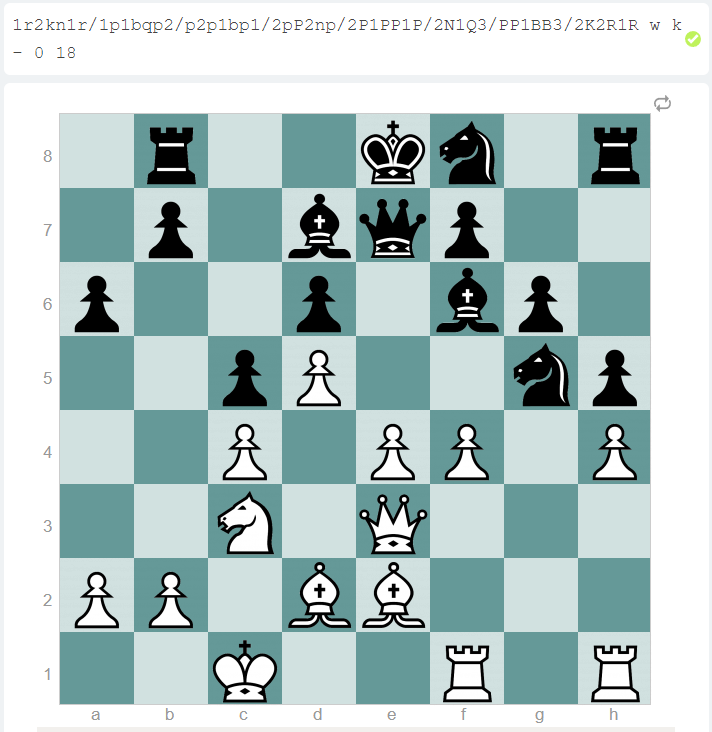

Código FEN: 1r2kn1r/1p1bqp2/p2p1bp1/2pP2np/2P1PP1P/2N1Q3/PP1BB3/2K2R1R w k - 0 18
Probabilidade de Checkmate: 0.0115
--------------------------------------------------


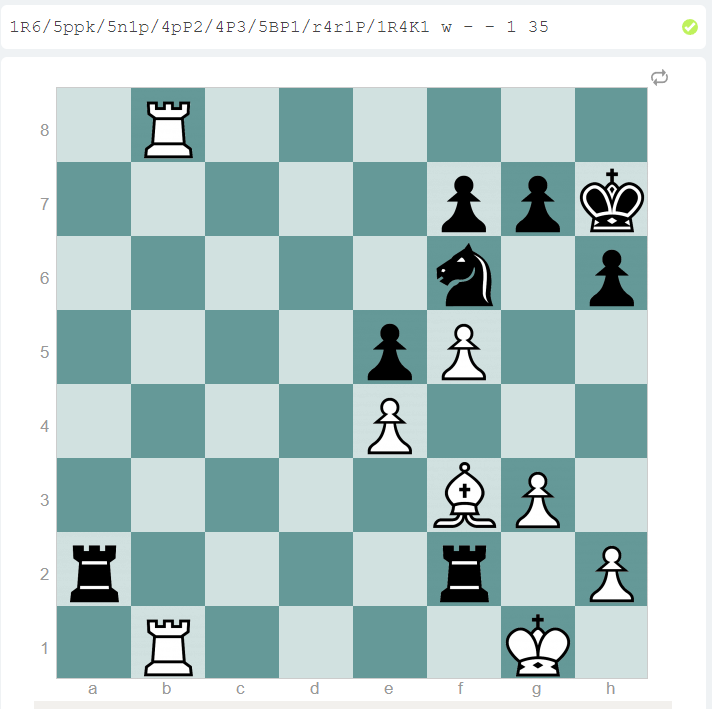

Código FEN: 1R6/5ppk/5n1p/4pP2/4P3/5BP1/r4r1P/1R4K1 w - - 1 35
Probabilidade de Checkmate: 0.7182
--------------------------------------------------


In [47]:
import os
from IPython.display import display, Image

# Lista das amostras de FEN e as predições
fens_para_predicao = [
    "4r3/1p2k1pp/r1p5/p1n5/P1P1Pp2/2N2P2/1PR2K1P/6R1 b - - 1 28",
    "1r4rk/1p1q1p1p/p3npb1/3pp3/PP4QN/1BPPR1PP/5P1K/R7 w - - 0 24",
    "4n3/p2k2p1/1p3p1p/5P1P/1BP3P1/1P6/PK1Q2q1/8 b - - 6 41",
    "1r2kn1r/1p1bqp2/p2p1bp1/2pP2np/2P1PP1P/2N1Q3/PP1BB3/2K2R1R w k - 0 18",
    "1R6/5ppk/5n1p/4pP2/4P3/5BP1/r4r1P/1R4K1 w - - 1 35"
]
predicoes = [0.2321, 0.0651, 0.8129, 0.0115, 0.7182]

# Caminho da pasta onde as imagens estão salvas
imgs_pasta = 'imgs/'

# Exibir as imagens e predições
for fen, pred in zip(fens_para_predicao, predicoes):
    # Nome da imagem (pode ser ajustado conforme o formato dos nomes de arquivo)
    img_nome = f"image{fens_para_predicao.index(fen)+1}.png"
    
    # Caminho completo para a imagem
    img_caminho = os.path.join(imgs_pasta, img_nome)

    # Exibir a imagem
    display(Image(img_caminho))

    # Exibir o código FEN e a probabilidade de checkmate
    print(f"Código FEN: {fen}")
    print(f"Probabilidade de Checkmate: {pred:.4f}")
    print("-" * 50)


## TENTATIVA COM RNN

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Função para dividir o FEN em linhas
def split_fen_into_lines(fen):
    clean_fen = fen.split(' ')[0]  # Pega apenas o tabuleiro, removendo os metadados finais
    return clean_fen.split('/')  # Divide o tabuleiro em 8 linhas  # Cada linha do tabuleiro é separada por '/'

# Exemplo
exemplo_fen = "4r3/1p2k1pp/r1p5/p1n5/P1P1Pp2/2N2P2/1PR2K1P/6R1 b - - 1 28"
print(split_fen_into_lines(exemplo_fen))


['4r3', '1p2k1pp', 'r1p5', 'p1n5', 'P1P1Pp2', '2N2P2', '1PR2K1P', '6R1']


In [18]:
balanced_data

,FEN,Evaluation
0,1r4k1/2n3bp/pN1p2p1/P1pPp3/8/1rBq1P1P/RPQ2RP1/...,-57
1,8/k3Kp2/2QB1P2/8/6q1/8/5P2/8 w - - 3 71,#+4
2,6k1/p2n3p/2bP4/2p2ppq/2N5/1PQ4P/PB6/4R1K1 b - ...,#+7
3,r2k4/N7/1KP5/8/1P4p1/6B1/8/8 w - - 2 63,#+15
4,b2rqrk1/p1p5/1p2p2Q/1P2Pp2/2P5/PR6/2B3PP/3R2K1...,#+7
...,...,...
380303,1k6/2p1r3/1p1p1pq1/pP1P3p/P2QPR2/6KP/6P1/8 w -...,0
380304,3r1rk1/pb2bppp/2p1p3/8/3PB3/2B5/PP2KPPP/R2R4 b...,-12
380305,r2q2kr/ppp1nR2/2np3p/6pB/NP2P1N1/2PPP3/P5PP/R2...,#+1
380306,1R2R3/5p1k/p6p/3p3b/2p3pq/2P3p1/P2N1bP1/5N1K w...,#-1


In [26]:
processed_data = balanced_data.copy()

processed_data['FEN_Lines'] = processed_data['FEN'].apply(split_fen_into_lines)

processed_data['MATE'] = processed_data['Evaluation'].apply(mate_column)

print(processed_data[['FEN', 'FEN_Lines']].head())

                                                 FEN  \
0  1r4k1/2n3bp/pN1p2p1/P1pPp3/8/1rBq1P1P/RPQ2RP1/...   
1            8/k3Kp2/2QB1P2/8/6q1/8/5P2/8 w - - 3 71   
2  6k1/p2n3p/2bP4/2p2ppq/2N5/1PQ4P/PB6/4R1K1 b - ...   
3            r2k4/N7/1KP5/8/1P4p1/6B1/8/8 w - - 2 63   
4  b2rqrk1/p1p5/1p2p2Q/1P2Pp2/2P5/PR6/2B3PP/3R2K1...   

                                           FEN_Lines  
0  [1r4k1, 2n3bp, pN1p2p1, P1pPp3, 8, 1rBq1P1P, R...  
1              [8, k3Kp2, 2QB1P2, 8, 6q1, 8, 5P2, 8]  
2  [6k1, p2n3p, 2bP4, 2p2ppq, 2N5, 1PQ4P, PB6, 4R...  
3              [r2k4, N7, 1KP5, 8, 1P4p1, 6B1, 8, 8]  
4  [b2rqrk1, p1p5, 1p2p2Q, 1P2Pp2, 2P5, PR6, 2B3P...  


In [27]:
processed_data

,FEN,Evaluation,FEN_Lines,MATE
0,1r4k1/2n3bp/pN1p2p1/P1pPp3/8/1rBq1P1P/RPQ2RP1/...,-57,"[1r4k1, 2n3bp, pN1p2p1, P1pPp3, 8, 1rBq1P1P, R...",False
1,8/k3Kp2/2QB1P2/8/6q1/8/5P2/8 w - - 3 71,#+4,"[8, k3Kp2, 2QB1P2, 8, 6q1, 8, 5P2, 8]",True
2,6k1/p2n3p/2bP4/2p2ppq/2N5/1PQ4P/PB6/4R1K1 b - ...,#+7,"[6k1, p2n3p, 2bP4, 2p2ppq, 2N5, 1PQ4P, PB6, 4R...",True
3,r2k4/N7/1KP5/8/1P4p1/6B1/8/8 w - - 2 63,#+15,"[r2k4, N7, 1KP5, 8, 1P4p1, 6B1, 8, 8]",True
4,b2rqrk1/p1p5/1p2p2Q/1P2Pp2/2P5/PR6/2B3PP/3R2K1...,#+7,"[b2rqrk1, p1p5, 1p2p2Q, 1P2Pp2, 2P5, PR6, 2B3P...",True
...,...,...,...,...
380303,1k6/2p1r3/1p1p1pq1/pP1P3p/P2QPR2/6KP/6P1/8 w -...,0,"[1k6, 2p1r3, 1p1p1pq1, pP1P3p, P2QPR2, 6KP, 6P...",False
380304,3r1rk1/pb2bppp/2p1p3/8/3PB3/2B5/PP2KPPP/R2R4 b...,-12,"[3r1rk1, pb2bppp, 2p1p3, 8, 3PB3, 2B5, PP2KPPP...",False
380305,r2q2kr/ppp1nR2/2np3p/6pB/NP2P1N1/2PPP3/P5PP/R2...,#+1,"[r2q2kr, ppp1nR2, 2np3p, 6pB, NP2P1N1, 2PPP3, ...",True
380306,1R2R3/5p1k/p6p/3p3b/2p3pq/2P3p1/P2N1bP1/5N1K w...,#-1,"[1R2R3, 5p1k, p6p, 3p3b, 2p3pq, 2P3p1, P2N1bP1...",True


In [28]:
# Inicializar o tokenizador no nível de caracteres
tokenizer = Tokenizer(char_level=True, oov_token='UNK')  # oov_token para tokens desconhecidos

# Preparar todas as linhas para treinamento
all_lines = [line for lines in processed_data['FEN_Lines'] for line in lines]  # Flatten da lista

# Ajustar o tokenizador ao conjunto de linhas
tokenizer.fit_on_texts(all_lines)

# Converter as linhas FEN em sequências numéricas
processed_data['FEN_Tokens'] = processed_data['FEN_Lines'].apply(
    lambda lines: tokenizer.texts_to_sequences(lines)
)

# Exibir exemplo da tokenização
print("Exemplo de tokenização:")
print(processed_data[['FEN_Lines', 'FEN_Tokens']].head())

Exemplo de tokenização:
                                           FEN_Lines  \
0  [1r4k1, 2n3bp, pN1p2p1, P1pPp3, 8, 1rBq1P1P, R...   
1              [8, k3Kp2, 2QB1P2, 8, 6q1, 8, 5P2, 8]   
2  [6k1, p2n3p, 2bP4, 2p2ppq, 2N5, 1PQ4P, PB6, 4R...   
3              [r2k4, N7, 1KP5, 8, 1P4p1, 6B1, 8, 8]   
4  [b2rqrk1, p1p5, 1p2p2Q, 1P2Pp2, 2P5, PR6, 2B3P...   

                                          FEN_Tokens  
0  [[3, 5, 8, 7, 3], [4, 10, 6, 9, 2], [2, 10, 3,...  
1  [[12], [7, 6, 7, 2, 4], [4, 11, 9, 3, 2, 4], [...  
2  [[14, 7, 3], [2, 4, 10, 6, 2], [4, 9, 2, 8], [...  
3  [[5, 4, 7, 8], [10, 15], [3, 7, 2, 13], [12], ...  
4  [[9, 4, 5, 11, 5, 7, 3], [2, 3, 2, 13], [3, 2,...  


In [29]:
# Definir o comprimento máximo para padding
max_len = max(len(line) for lines in processed_data['FEN_Tokens'] for line in lines)

# Aplicar padding em todas as linhas
processed_data['FEN_Padded'] = processed_data['FEN_Tokens'].apply(
    lambda lines: pad_sequences(lines, maxlen=max_len, padding='post')
)

# Exibir o resultado final
print("Exemplo com padding:")
print(processed_data[['FEN_Tokens', 'FEN_Padded']].head())


Exemplo com padding:
                                          FEN_Tokens  \
0  [[3, 5, 8, 7, 3], [4, 10, 6, 9, 2], [2, 10, 3,...   
1  [[12], [7, 6, 7, 2, 4], [4, 11, 9, 3, 2, 4], [...   
2  [[14, 7, 3], [2, 4, 10, 6, 2], [4, 9, 2, 8], [...   
3  [[5, 4, 7, 8], [10, 15], [3, 7, 2, 13], [12], ...   
4  [[9, 4, 5, 11, 5, 7, 3], [2, 3, 2, 13], [3, 2,...   

                                          FEN_Padded  
0  [[3, 5, 8, 7, 3, 0, 0, 0], [4, 10, 6, 9, 2, 0,...  
1  [[12, 0, 0, 0, 0, 0, 0, 0], [7, 6, 7, 2, 4, 0,...  
2  [[14, 7, 3, 0, 0, 0, 0, 0], [2, 4, 10, 6, 2, 0...  
3  [[5, 4, 7, 8, 0, 0, 0, 0], [10, 15, 0, 0, 0, 0...  
4  [[9, 4, 5, 11, 5, 7, 3, 0], [2, 3, 2, 13, 0, 0...  


In [42]:
X_lstm = np.array([
    np.concatenate(padded_lines) for padded_lines in processed_data['FEN_Padded']
])
y_lstm = processed_data['MATE'].to_numpy()  # Rótulo binário

# Certifique-se que a forma está correta
print(f"Formato corrigido de X_lstm: {X_lstm.shape}")  # Deve ser (n_amostras, sequence_length)
print(f"Tipo de dados: {X_lstm.dtype}")
print(f"Formato dos rótulos: {y_lstm.shape}")


Formato corrigido de X_lstm: (380308, 64)
Tipo de dados: int32
Formato dos rótulos: (380308,)


In [47]:
pip show tensorflow


Name: tensorflow
Version: 2.4.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/npad/shared/conda/gpu-tf/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras-preprocessing, numpy, opt-einsum, protobuf, six, tensorboard, tensorflow-estimator, termcolor, typing-extensions, wheel, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Definir o tamanho do vocabulário e comprimento da sequência
vocab_size = len(np.unique(X_lstm)) + 1  # Soma 1 para incluir o índice de padding
sequence_length = X_lstm.shape[1]  # Comprimento das sequências (64)

# Construir o modelo LSTM
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=32, input_length=sequence_length),  # Embedding Layer
    LSTM(64, return_sequences=True),  # Primeira camada LSTM (retorna sequências)
    Dropout(0.3),
    LSTM(64, return_sequences=False),  # Segunda camada LSTM
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Camada de saída para classificação binária
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()


NotImplementedError: Cannot convert a symbolic Tensor (lstm_10/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported